In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

# Set the root directory
root_dir = '/kaggle/input/plantvillage-dataset'

# List all immediate subdirectories (class names)
class_names = [dirname for dirname in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, dirname))]

# Print the class names
for class_name in class_names:
    print(class_name)

segmented
grayscale
plantvillage dataset
color


In [3]:
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import os

def data(dataset_path, num_classes=38):
    images = []
    labels = []
    
    # Get the list of subfolders (class names)
    subfolders = [subfolder for subfolder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subfolder))]
    
    # Limit the number of classes if num_classes is specified
    subfolders = subfolders[:num_classes]
    
    for subfolder in tqdm(subfolders):
        subfolder_path = os.path.join(dataset_path, subfolder)
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    
    df = pd.DataFrame({'image': images, 'label': labels})
    return df


In [4]:
segmented_path = '/kaggle/input/plantvillage-dataset/segmented'
train_segmented = data(segmented_path)
print(train_segmented.shape)
num_classes = train_segmented['label'].nunique()
print(f"Number of classes: {num_classes}")

100%|██████████| 38/38 [00:02<00:00, 13.11it/s]

(54306, 2)
Number of classes: 38


In [5]:
import gc

# Delete variables
del train_segmented, segmented_path

# Run garbage collection to free memory
gc.collect()

0

In [6]:
grayscale_path = '/kaggle/input/plantvillage-dataset/grayscale'
train_grayscale = data(grayscale_path)
print(train_grayscale.shape)
num_classes = train_grayscale['label'].nunique()
print(f"Number of classes: {num_classes}")

100%|██████████| 38/38 [00:05<00:00,  6.51it/s]

(54305, 2)
Number of classes: 38


In [7]:
import gc

# Delete variables
del train_grayscale, grayscale_path

# Run garbage collection to free memory
gc.collect()


0

In [8]:
color_path = '/kaggle/input/plantvillage-dataset/color'
train_color = data(color_path)
print(train_color.shape)
num_classes = train_color['label'].nunique()
print(f"Number of classes: {num_classes}")

100%|██████████| 38/38 [00:02<00:00, 14.76it/s]

(54305, 2)
Number of classes: 38


/tmp/ipykernel_23/2366528349.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


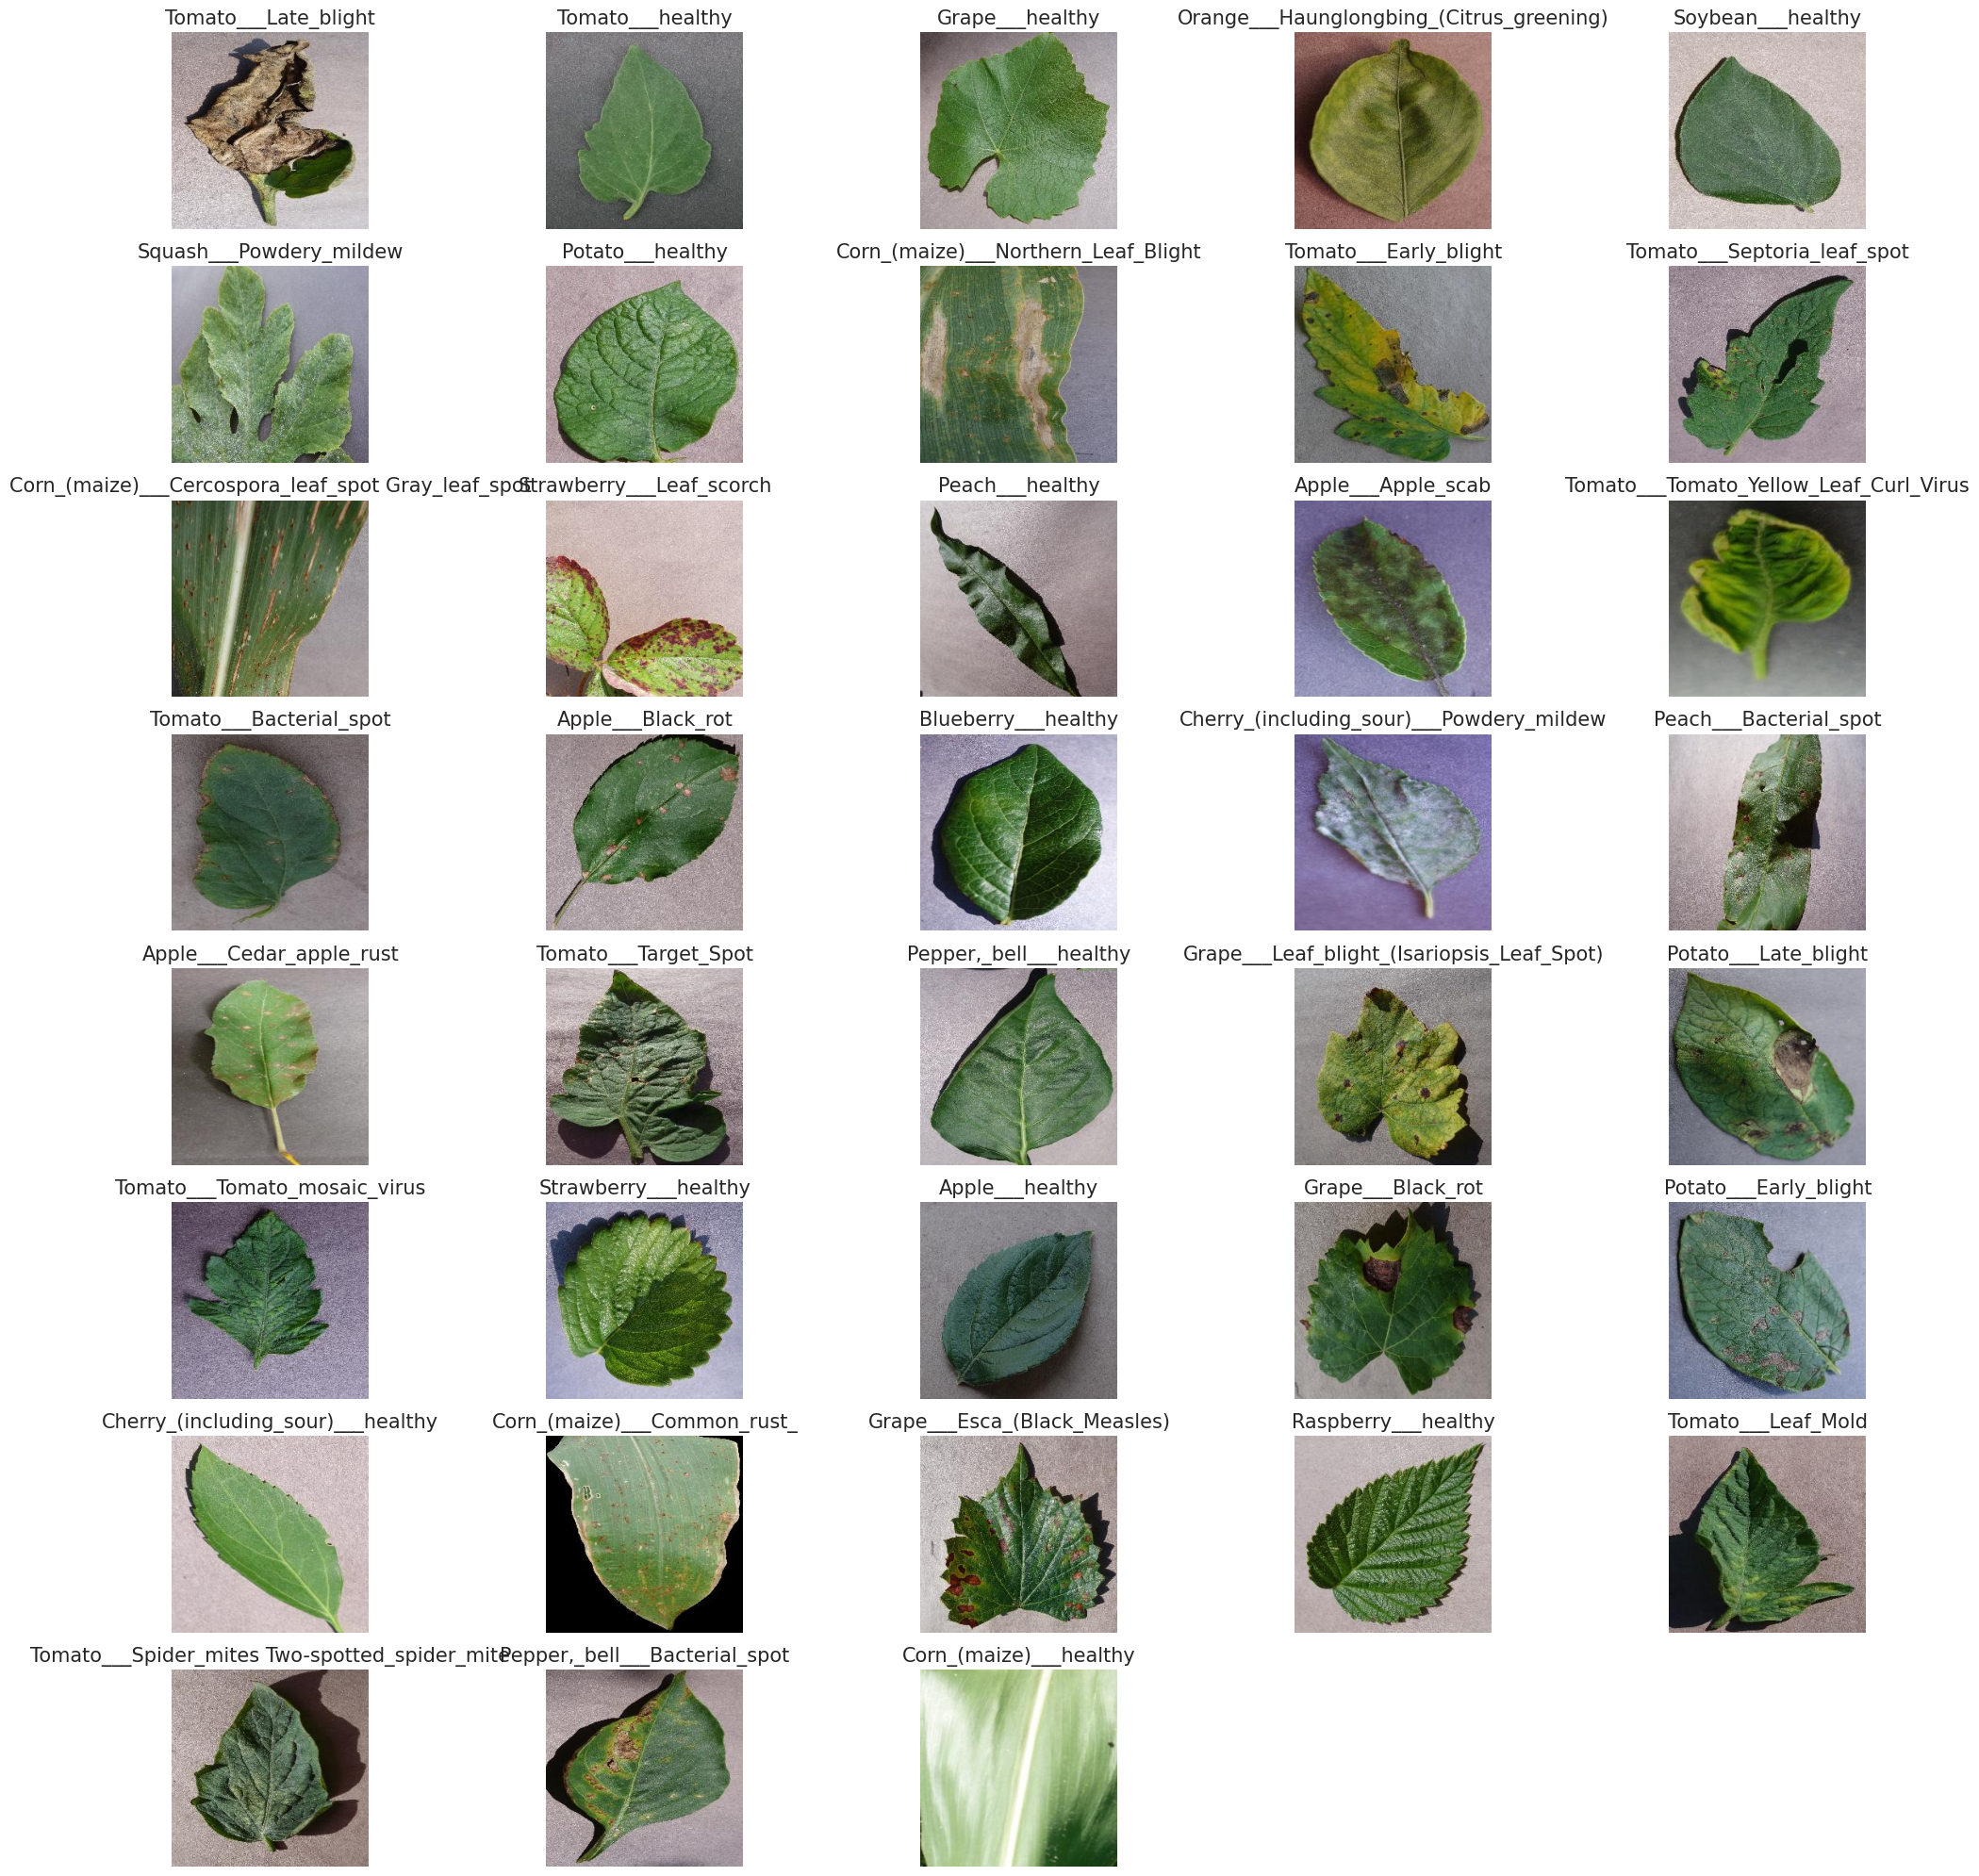

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# List all immediate subdirectories (class names)
class_names = [dirname for dirname in os.listdir(color_path) if os.path.isdir(os.path.join(color_path, dirname))]

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20, 20))

# Loop through each class
for idx, class_name in enumerate(class_names):
    # Get the path to the class directory
    class_dir = os.path.join(color_path, class_name)
    
    # List all images in the class directory
    image_files = [file for file in os.listdir(class_dir) if file.endswith(('.png', '.jpg', 'JPG', '.jpeg'))]
    
    if not image_files:
        continue  # Skip if no images are found in the class folder
    
    # Randomly select an image
    random_image = np.random.choice(image_files)
    
    # Load the image
    img_path = os.path.join(class_dir, random_image)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.subplot(len(class_names) // 5 + 1, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name, fontsize=15)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train, X_test1, y_train, y_test1 = train_test_split(train_color['image'], train_color['label'], test_size=0.2, random_state=42,shuffle=True,stratify=train_color['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [11]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_datagen = ImageDataGenerator(
    rescale=1./255, 
)
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 43444 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import AUC

In [13]:
# Number of output classes
num_classes = 38

# Load Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer with 50% rate
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout layer with 30% rate
predictions = Dense(num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Freeze the layers of Xception
for layer in base_model.layers:
    layer.trainable = False

# Initial learning rate
initial_lr = 1e-3

# Compile the model with AUC metric
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', AUC()]
)

# Callbacks
checkpoint_cb = ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Learning rate scheduler
def lr_schedule(epoch):
    decay_rate = 0.1
    decay_steps = 10
    return initial_lr * (decay_rate ** (epoch // decay_steps))

lr_scheduler_cb = LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

In [15]:
# Train the model (First Phase - Frozen Base Model)
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb, reduce_lr_cb]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734480114.014040      95 service.cc:145] XLA service 0x7a51c403c400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734480114.014103      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734480114.014110      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1358 ━━━━━━━━━━━━━━━━━━━━ 7:22:35 20s/step - accuracy: 0.0000e+00 - auc: 0.4405 - loss: 3.8673

I0000 00:00:1734480127.576950      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 301s 207ms/step - accuracy: 0.6547 - auc: 0.9610 - loss: 1.2191 - val_accuracy: 0.8762 - val_auc: 0.9968 - val_loss: 0.3881 - learning_rate: 0.0010
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 193s 142ms/step - accuracy: 0.8409 - auc: 0.9924 - loss: 0.5020 - val_accuracy: 0.8952 - val_auc: 0.9977 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 193s 142ms/step - accuracy: 0.8646 - auc: 0.9939 - loss: 0.4236 - val_accuracy: 0.9107 - val_auc: 0.9980 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 193s 141ms/step - accuracy: 0.8816 - auc: 0.9947 - loss: 0.3690 - val_accuracy: 0.9094 - val_auc: 0.9983 - val_loss: 0.2811 - learning_rate: 0.0010
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 193s 142ms/step - accuracy: 0.8872 - auc: 0.9949 - loss: 0.3500 - val_accuracy: 0.9177 - val_auc: 0.9974 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 193s 142ms/step - a

In [17]:
import tensorflow as tf

# Fine-tuning Phase
# Unfreeze some top layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', AUC()]
)

# Fine-tuning training
fine_tuning_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 274s 190ms/step - accuracy: 0.8042 - auc_1: 0.9690 - loss: 1.0126 - val_accuracy: 0.9381 - val_auc_1: 0.9980 - val_loss: 0.2001 - learning_rate: 1.0000e-05
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 246s 181ms/step - accuracy: 0.9259 - auc_1: 0.9961 - loss: 0.2450 - val_accuracy: 0.9517 - val_auc_1: 0.9986 - val_loss: 0.1539 - learning_rate: 1.0000e-05
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 246s 181ms/step - accuracy: 0.9463 - auc_1: 0.9983 - loss: 0.1645 - val_accuracy: 0.9604 - val_auc_1: 0.9987 - val_loss: 0.1308 - learning_rate: 1.0000e-05
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 246s 181ms/step - accuracy: 0.9577 - auc_1: 0.9986 - loss: 0.1291 - val_accuracy: 0.9654 - val_auc_1: 0.9987 - val_loss: 0.1201 - learning_rate: 1.0000e-05
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 245s 180ms/step - accuracy: 0.9654 - auc_1: 0.9990 - loss: 0.1078 - val_accuracy: 0.9681 - val_auc_1: 0.9985 - val_loss: 0.1123 - learning_rate: 1.0000e-05
Epoch 6/10

In [18]:
# Combine training histories
for key in history.history.keys():
    if key in fine_tuning_history.history:
        history.history[key].extend(fine_tuning_history.history[key])

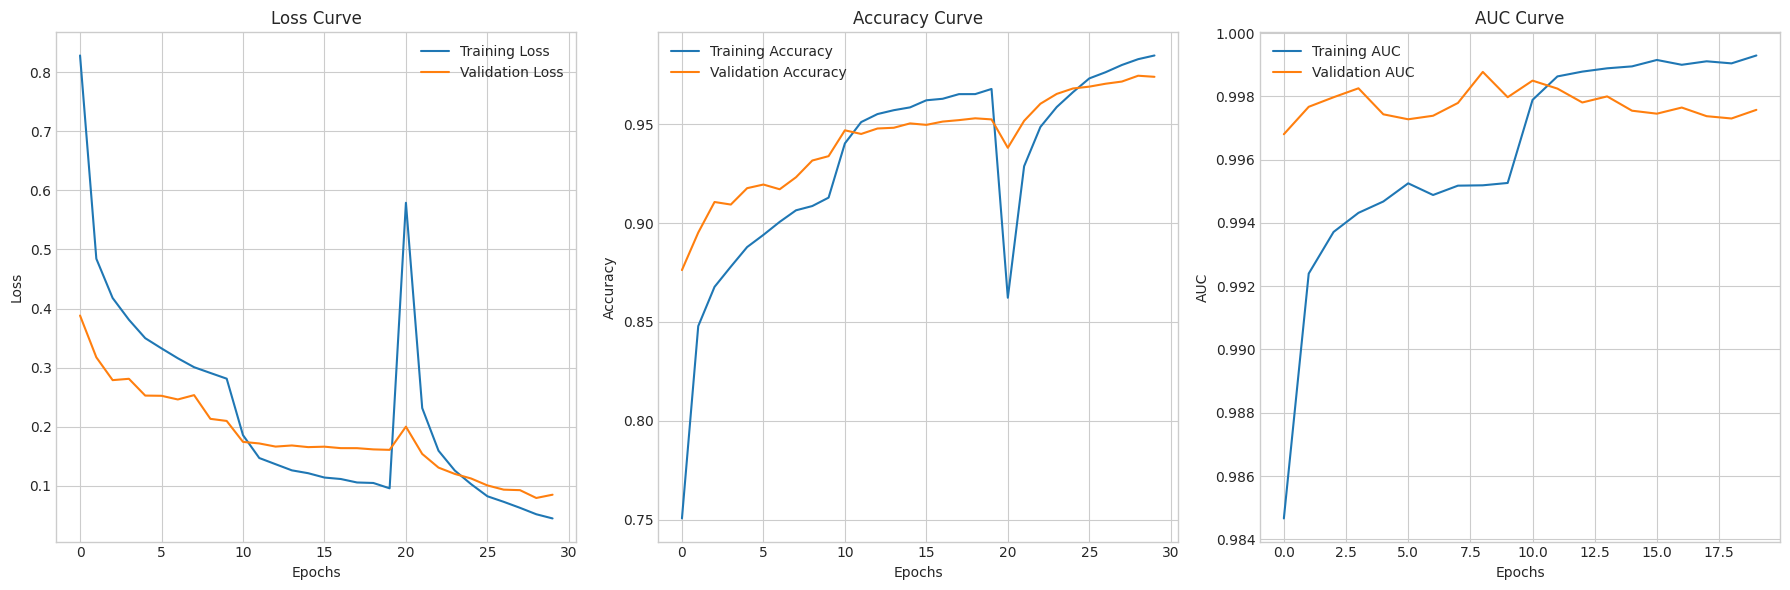

In [19]:
# Plot Metrics: Loss, Accuracy, and AUC
plt.figure(figsize=(18, 6))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# AUC Curve
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

Test Loss: 0.0891
Test Accuracy: 0.9761
Test AUC: 0.9985
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step


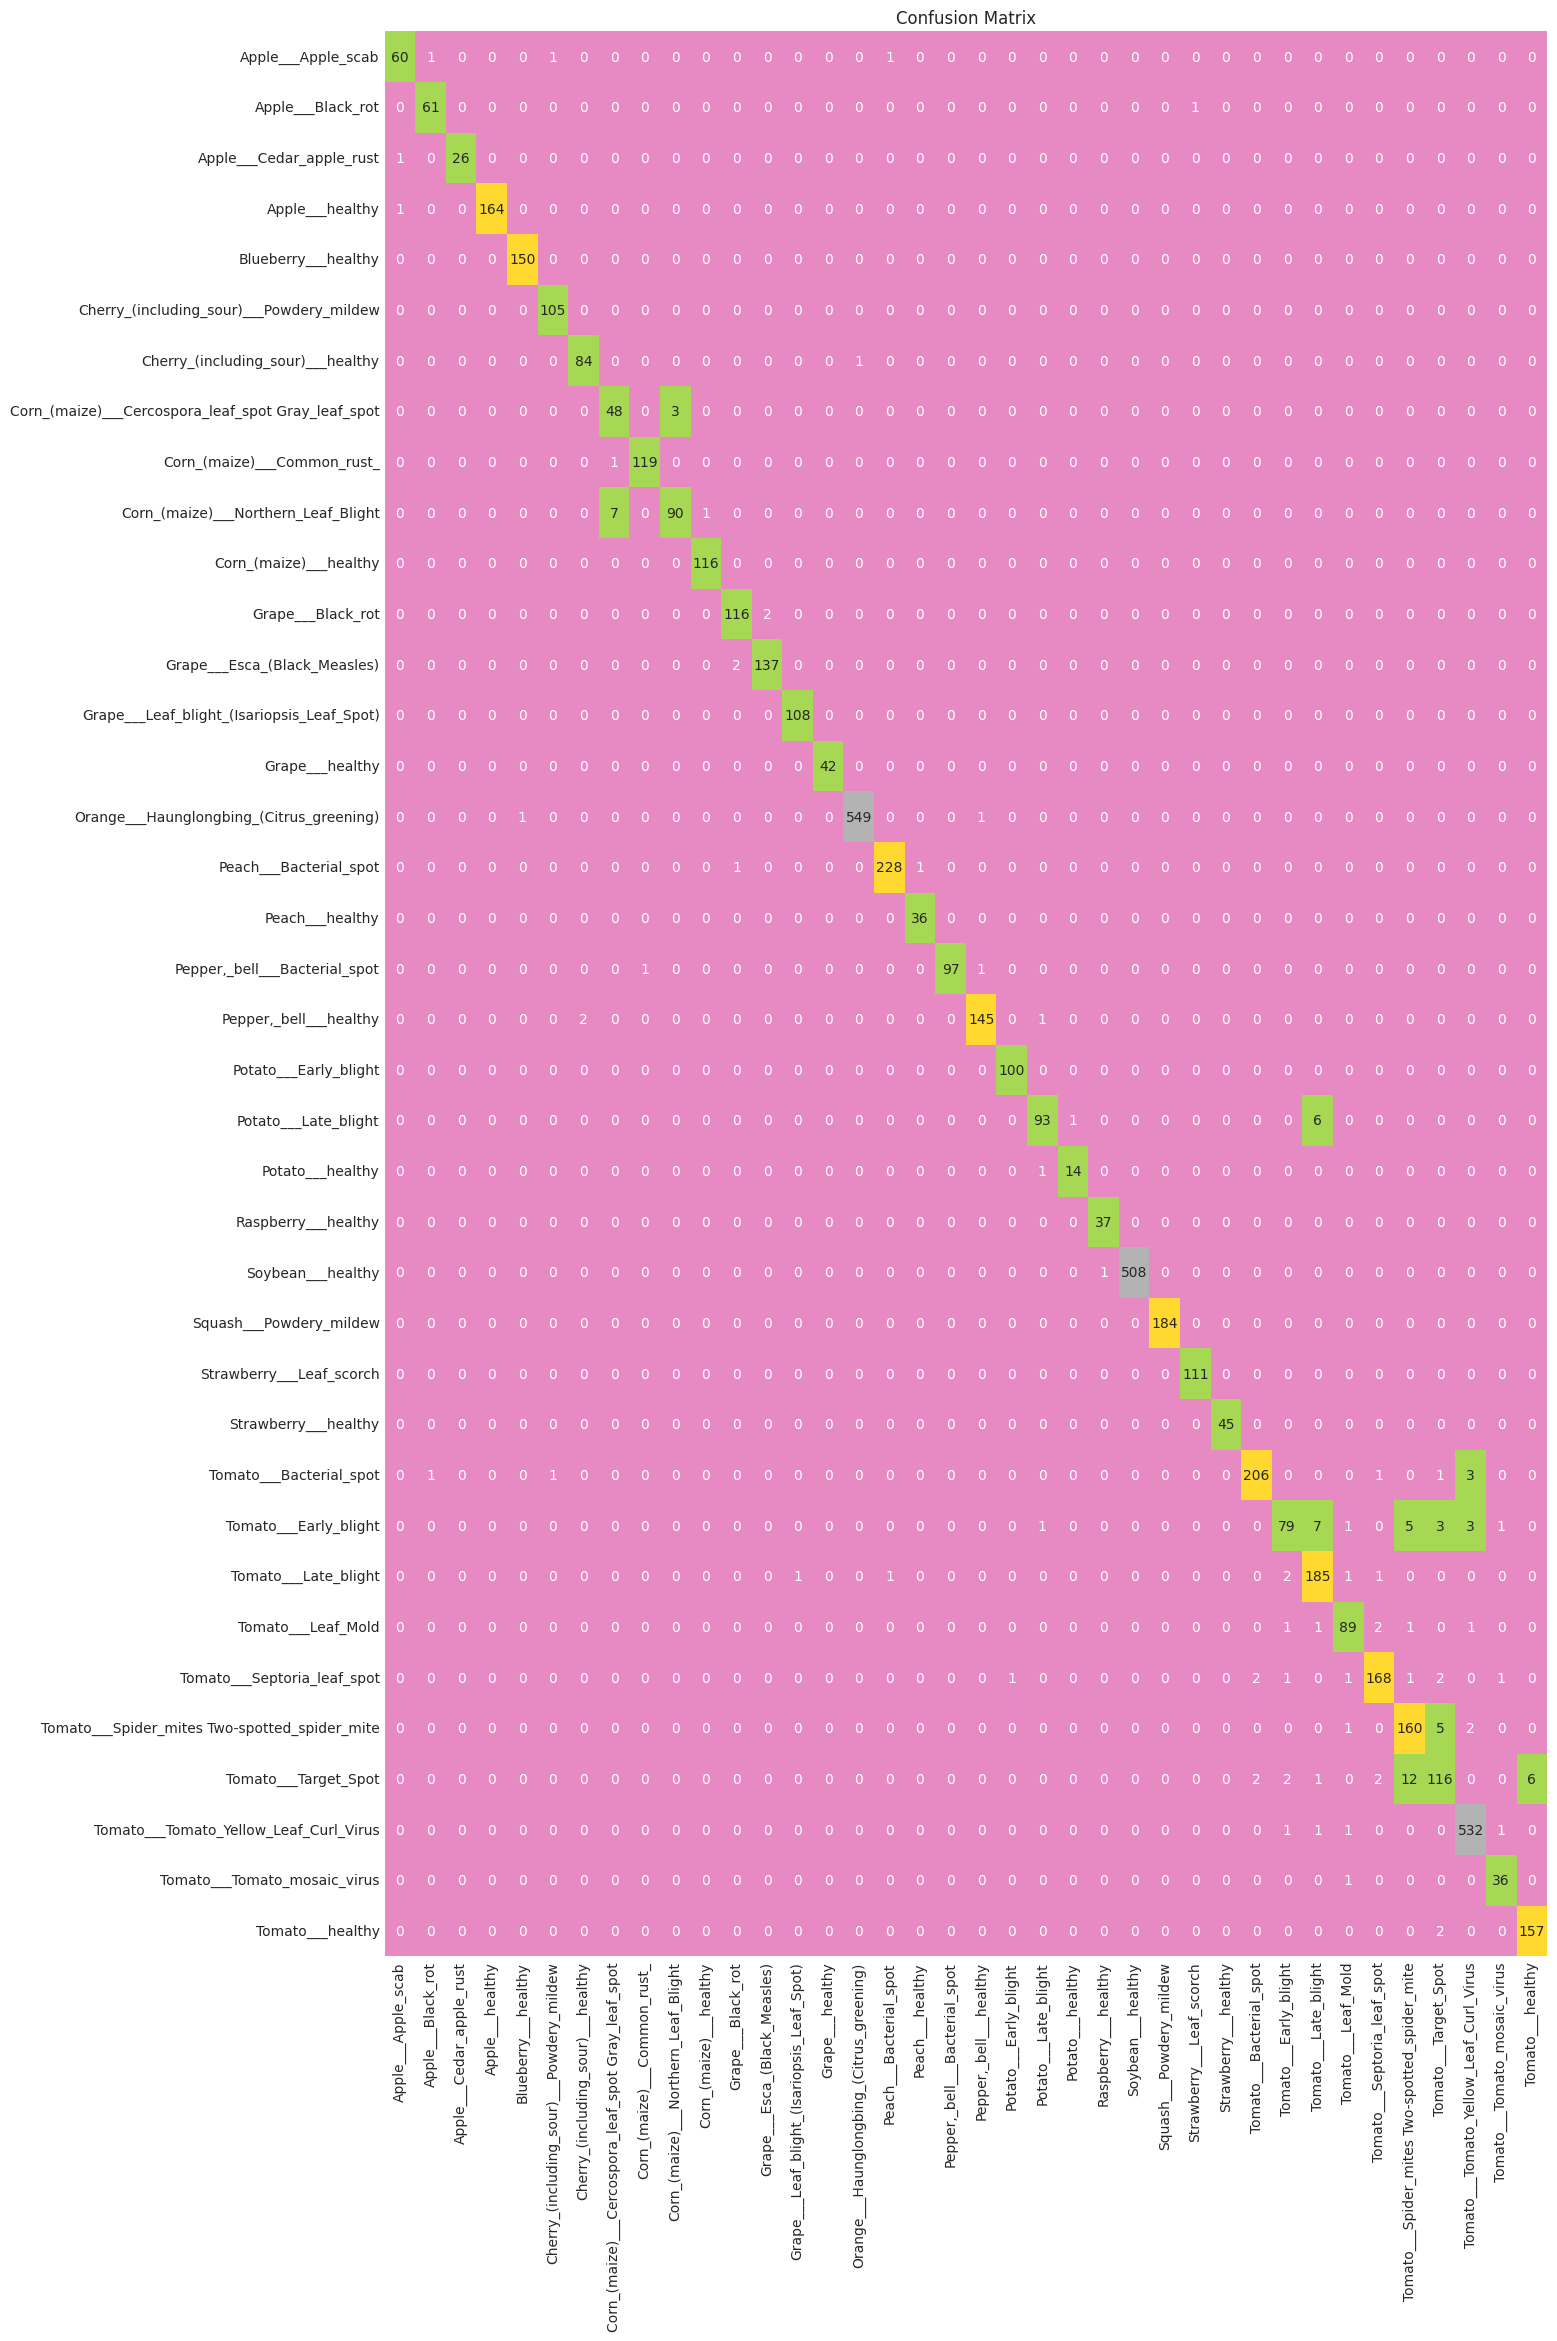

In [20]:
# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
CM = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 25))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Set2',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Classification Report
classification_report_str = classification_report(y_true, y_pred, target_names=class_labels)
print('Classification Report:\n', classification_report_str)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.95      0.96        63
                                 Apple___Black_rot       0.97      0.98      0.98        62
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        27
                                   Apple___healthy       1.00      0.99      1.00       165
                               Blueberry___healthy       0.99      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       0.98      1.00      0.99       105
                 Cherry_(including_sour)___healthy       0.98      0.99      0.98        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.94      0.90        51
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       120
               Corn_(maize)___Northern_Leaf_Blight     